# Lab 2: Physics Informed Neural Network (PINN)

## Burger’s equation

In one space dimension, the Burger’s equation along with Dirichlet boundary conditions reads as
$$
\frac{\partial u(t,x)}{\partial t} ~+~ u(t,x) \frac{\partial u(t,x)}{\partial x} ~=~ \nu \frac{\partial^2 u(t,x)}{\partial^2 x}, x\in[-1,1], t\in[0,1],\\
$$
$$
u(0,x)=-\sin(\pi x),\\
$$
$$
u(t,-1)=u(t,1)=0.
$$
The goal is to compute the function $u(t,x)$ solution of this Partial Derivative Equation (PDE) for $\nu= \frac{0.01}{\pi}$, where $t$ is the time and $x$ the spatial location.

Let us define the "residual function" $f(t,x)$ which should vanish for all $x$ and $t$:
$$
f(t,x)=\frac{\partial u(t,x)}{\partial t} ~+~ u(t,x) \frac{\partial u(t,x)}{\partial x} ~-~ \nu \frac{\partial^2 u(t,x)}{\partial^2 x}.
$$

The function $u(t,x)$ will be approximated by a neural network.


## How to learn the solution?

The shared parameters between the neural networks $u(t,x)$ and $f(t,x)$ can be learned by minimizing the mean squared error loss

$$
MSE = MSE_u + MSE_f
$$
where
$$
MSE_u=\frac{1}{N_u}\sum_{i=1}^{N_u}{(u(t_u^i,x_u^i)-u^i)}^2
$$
and
$$
MSE_f=\frac{1}{N_f}\sum_{i=1}^{N_f}{(f(t_f^i,x_f^i))}^2
$$

Here, $\{t_u^i,x_u^i,u^i\}$ denote the initial and boundary training data on $u(t, x)$ and $\{t_f^i , x_f^i\}$ specify the collocation points for $f(t, x)$.

Import all the required libraries

In [50]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [51]:
%matplotlib inline

import torch
import numpy as np
import os
import time
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.autograd import grad

## Numerical solution

The following cell use the function "burgers_viscous_time_exact1" that gives a very accurate numerical solution. This solution does not rely on deep neural networks. It will be the reference solution for our deep neural network based solution.

In [52]:
from burgersnumlib import burgers_viscous_time_exact1

# Define the discretization grid and the parameters of the Burger equation
vtn = 40 # number of time samples
vxn = 20 # number of space samples
nu = 0.01 / np.pi

# Space discretization
xlo = -1.0
xhi = +1.0
vx = np.linspace ( xlo, xhi, vxn )

# Time discretization
tlo = 0.0
thi = 1.0
vt = np.linspace ( tlo, thi, vtn )

# Compute the solution
# Each column of "u_true" corresponds to a given time
u_true = burgers_viscous_time_exact1 ( nu, vxn, vx, vtn, vt )
u_true = np.transpose(u_true) # we transpose the result because the burger simulation returns the function u(x,t) instead of u(t,x)

# Check the size of the solution
print(u_true.shape)

(40, 20)


In [53]:
# Transform the input into a list of vectors
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

In [54]:
# Example for "flat"
x = torch.arange(0, 4, 1.0).reshape(2, 2)
print(x)
print(flat(x))

tensor([[0., 1.],
        [2., 3.]])
[tensor([0., 1.]), tensor([2., 3.])]


In [55]:
# This function computes the n-th order derivative of a function f
# f: the function
# x: inputs
# n: the order of derivation

# FYI (For Your Information):
# create_graph (bool, optional) – If True, graph of the derivative will be constructed,
# allowing to compute higher order derivative products. Default: False.

def nth_derivative(f, x, n):
    for i in range(n):
        grads = grad(f, x, create_graph=True, allow_unused=True)[0]
        f = grads
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

In [56]:
# Example for "nth_derivative"
x = torch.arange(0, 4, 1.0, requires_grad=True).reshape(2, 2)
loss = (x ** 4).sum()

print(x)
print(nth_derivative(f=loss, x=x, n=1)) # Gradient calculated numerically
print(4*x**3) # Gradient calculated by hand


tensor([[0., 1.],
        [2., 3.]], grad_fn=<ViewBackward0>)
tensor([[  0.,   4.],
        [ 32., 108.]], grad_fn=<MulBackward0>)
tensor([[  0.,   4.],
        [ 32., 108.]], grad_fn=<MulBackward0>)


## Define the Neural Network class.

We want to implement the following neural network:

Input -> Linear -> Tanh -> Hidden 1

-> Linear -> Tanh -> Hidden 2

-> Linear -> Tanh -> Hidden 3

-> Linear -> Tanh -> Hidden 4

-> Linear -> Output

The neural network will be a function:

$$
net(t,x):~ [0, 1] \times [-1, 1]~  \mapsto ~ \mathbb{R}
$$

### Question: what is the input of the neural network during the training?

Explanation:...

### Question: Code the neural network in the following "forward" function.

You must remove the keywork "pass" and replace it by your code.

In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.il  = nn.Linear(2,80)
        self.hl1 = nn.Linear(80,80)
        self.hl2 = nn.Linear(80,80)
        self.hl3 = nn.Linear(80,40)
        self.ol  = nn.Linear(40,1)
        self.tn  = nn.Tanh()

    def forward(self,t,x):
        u = torch.cat((t, x), 1)
        u = self.il(u)
        u = self.tn(u)
        u = self.hl1(u)
        u = self.tn(u)
        u = self.hl2(u)
        u = self.tn(u)
        u = self.hl3(u)
        u = self.tn(u)
        u = self.ol(u)
        return u


##Define Residual function

In [58]:
def f(t,x):
    u = mynet(t,x)
    u_t = nth_derivative(flat(u), x=t, n=1)
    u_x = nth_derivative(flat(u), x=x, n=1)
    u_xx = nth_derivative(flat(u_x), x=x, n=1)
    eta = torch.tensor(0.01/np.pi)
    f = u_t + u*u_x - eta*u_xx
    return f

### Initial conditions and boundaries of the PDE solution:

$$
u(0,x)=-\sin(\pi x),\\
$$
$$
u(t,-1)=u(t,1)=0.
$$

Conversion into Pytorch tensors and set up the gradient status

In [59]:
# ivx is the set of x axis points as a tensor
ivx = torch.from_numpy(vx).float()
ivx =  ivx.reshape(vxn,1)
ivx.requires_grad = True

# ivt is the set of t axis points as a tensor
ivt = torch.from_numpy(vt).float()
ivt = ivt.reshape(vtn,1)
ivt.requires_grad = True

## Define the first training set for the boundary conditions

### Question: how to interpret the set "full_u"?

In [60]:
# we need to create the boundary conditions.
# There are three segments when x = -1, x = 1 and t=0
# it0 is t=0 for all x values (hence, it is a zero tensor of size "vxn")
# ix1 is x=1 for all t (hence, it is a one tensor of size "vtn")
# ixm1 is x=-1 for all t (hence, it is a minus one tensor of size "vtn")
it0 = torch.zeros(vxn, dtype=torch.float, requires_grad=True).reshape(vxn,1)
ix1 = torch.zeros(vtn, dtype=torch.float, requires_grad=True).reshape(vtn,1)+1.0
ixm1  = torch.zeros(vtn, dtype=torch.float, requires_grad=True).reshape(vtn,1)-1.0

# Now the values for u on the above boundary segments
# We use the numerical solution to get the boundary conditions
#t is fixed to 0 and we fill the BC for all the x
xbndr = torch.from_numpy(-np.sin(np.pi*vx)).float().reshape(vxn,1) # boundary u(0,x) at t = 0

# Generate the tensors containing the triplets (t,x,u(t,x)) for the boundary conditions
# Each tensor is obtained by concatenating horizontally the 3 basic tensors of a specific condition
# There are 3 "full" tensors because there are 3 conditions
full_it0  = torch.cat((it0, ivx, xbndr),dim=1) # get all the triplets (0,x,u(0,x))
full_ixm1 = torch.cat((ivt, ixm1, torch.zeros(vtn,1)),dim=1) # get all the triplets (t,-1, u(t,-1))
full_ix1  = torch.cat((ivt, ix1, torch.zeros(vtn,1)),dim=1) # get all the triplets (t,1, u(t,1))

# Concatenate all the boundary condition tensors
full_u = torch.cat((full_it0, full_ixm1, full_ix1), dim=0) # concatenate vertically the 3 tensors

## Define the second training set for $f(t,x)$

### Question: how to interpret "full_f"?

In [61]:
grid_ivt, grid_ivx = torch.meshgrid(ivt.squeeze(), ivx.squeeze(), indexing="ij") # sampling the 2D domain of f(t,x)
print(ivt[3][0])
print(ivt.squeeze()[3])
grid_ivt_1D = grid_ivt.reshape([-1,1]) # convert into 1D vector
grid_ivx_1D = grid_ivx.reshape([-1,1]) # convert into 1D vector
zeros = torch.zeros(grid_ivt_1D.size(), dtype=torch.float, requires_grad=True) # create a vector filled in with 0
full_f = torch.cat((grid_ivt_1D, grid_ivx_1D, zeros),dim=1) # concatenate the 3 tensors
print(full_f)

tensor(0.0769, grad_fn=<SelectBackward0>)
tensor(0.0769, grad_fn=<SelectBackward0>)
tensor([[ 0.0000, -1.0000,  0.0000],
        [ 0.0000, -0.8947,  0.0000],
        [ 0.0000, -0.7895,  0.0000],
        ...,
        [ 1.0000,  0.7895,  0.0000],
        [ 1.0000,  0.8947,  0.0000],
        [ 1.0000,  1.0000,  0.0000]], grad_fn=<CatBackward0>)


### Just a check

Run the neural network to check its behavior (with random weights)

In [62]:
mynet =  Net()
u = mynet(it0,ivx) # compute u(0,x) for all x
print(u.shape)

torch.Size([20, 1])


## Train the neural network

### Question: what is an epoch?


Explanation:...

In [63]:
# number of epochs
epochs = 4000

# Define the learning rate
learning_rate = 0.001

Initialization of the train step

In [64]:
# instantiate the neural network
mynet = Net()

# Set the loss function
loss_fn = nn.MSELoss()

# Use Adam optimizer
optimizer = optim.Adam(mynet.parameters(), lr=learning_rate)


### Question: why do we set "retain_graph=True"?

Explanation:...

In [65]:
for epoc in range(1, epochs+1):
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Compute the outputs of the network
    outputs_u = mynet(torch.narrow(full_u,1,0,1), torch.narrow(full_u,1,1,1))
    outputs_f = f(torch.narrow(full_f,1,0,1), torch.narrow(full_f,1,1,1)) # narrow extracts a column

    # Compute the two losses:
    # 1- We must minimize the function f(x,t)
    # 2- And we must also check the boundary constraints
    mse_u = loss_fn(outputs_u, torch.narrow(full_u,1,2,1))
    mse_f = loss_fn(outputs_f, torch.narrow(full_f,1,2,1) )

    # We want to minimize the sum of losses
    mse = mse_u + mse_f

    # Backward pass: compute gradient of the loss with respect to model parameters
    mse.backward(retain_graph=True)

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    if epoc % 200 == 0:
        # print the epoc information on screen
        print('epoc %d; boundary loss %f, function loss %f, sum loss %f'
              %(epoc, float(mse_u), float(mse_f), float(mse) ) )

epoc 200; boundary loss 0.035610, function loss 0.007730, sum loss 0.043339
epoc 400; boundary loss 0.026894, function loss 0.006791, sum loss 0.033685
epoc 600; boundary loss 0.020346, function loss 0.005075, sum loss 0.025420
epoc 800; boundary loss 0.014905, function loss 0.005042, sum loss 0.019947
epoc 1000; boundary loss 0.016046, function loss 0.012108, sum loss 0.028155
epoc 1200; boundary loss 0.010530, function loss 0.003069, sum loss 0.013599
epoc 1400; boundary loss 0.012174, function loss 0.002997, sum loss 0.015171
epoc 1600; boundary loss 0.013610, function loss 0.002642, sum loss 0.016252
epoc 1800; boundary loss 0.009868, function loss 0.002361, sum loss 0.012229
epoc 2000; boundary loss 0.005243, function loss 0.002061, sum loss 0.007304
epoc 2200; boundary loss 0.002761, function loss 0.002428, sum loss 0.005189
epoc 2400; boundary loss 0.001145, function loss 0.001178, sum loss 0.002323
epoc 2600; boundary loss 0.000753, function loss 0.000966, sum loss 0.001718
epo

### Plot the solution

Plot the solution at time t=0

(20, 1)


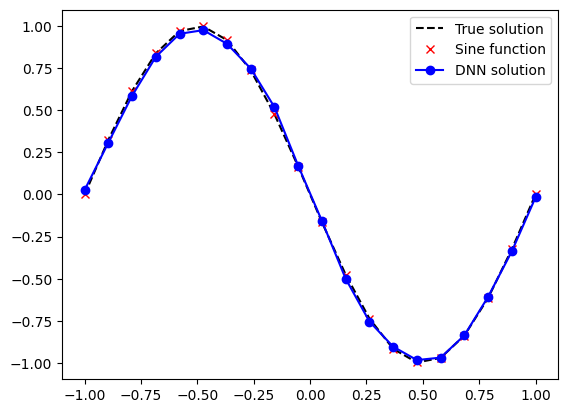

In [66]:
u = mynet(it0,ivx)
uu = u.detach().numpy()
print(uu.shape)
plt.plot(vx, u_true[0,:],'k--',label='True solution')
plt.plot(vx, -np.sin(np.pi*vx),'rx',label='Sine function')
plt.plot(vx, u.detach().numpy(),'b-o',label='DNN solution')
plt.legend()
plt.show()

Plot the function $u(t,x)$ as a function of $x$ at four specific times

In [67]:
# Compute the solution for all couples (t,x)
u = mynet(grid_ivt_1D, grid_ivx_1D).reshape(vtn,vxn).detach().numpy()
print(u.shape)

(40, 20)


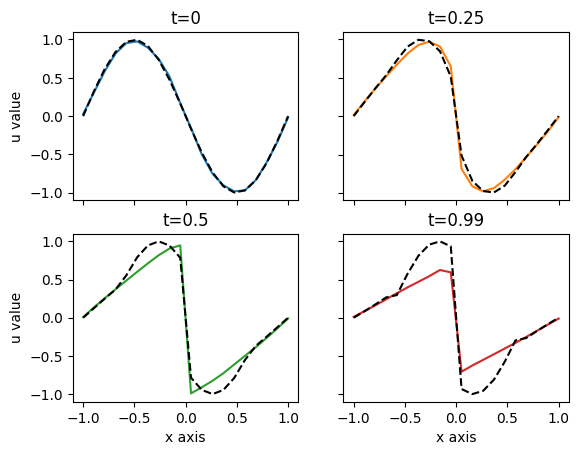

In [68]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(vx, u[0,:])
axs[0, 0].plot(vx, u_true[0,:],'k--')
axs[0, 0].set_title('t=0')

axs[0, 1].set_title('t=0.25')
axs[0, 1].plot(vx, u[int(vtn/4),:],  'tab:orange')
axs[0, 1].plot(vx, u_true[int(vtn/4),:],'k--')

axs[1, 0].set_title('t=0.5')
axs[1, 0].plot(vx, u[int(vtn/2),:],  'tab:green')
axs[1, 0].plot(vx, u_true[int(vtn/2),:],'k--')

axs[1, 1].set_title('t=0.99')
axs[1, 1].plot(vx, u[vtn-1,:], 'tab:red')
axs[1, 1].plot(vx, u_true[vtn-1,:],'k--')

for ax in axs.flat:
    ax.set(xlabel='x axis', ylabel='u value')
for ax in axs.flat:
    ax.label_outer()